In [96]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')

In [97]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

In [98]:
def dy(x):
    return 1 - (tanh(x) ** 2)

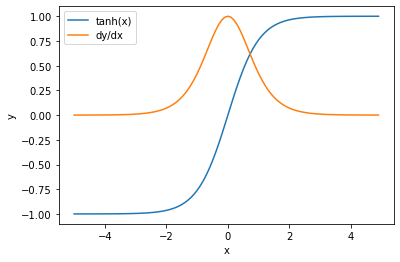

In [99]:
### tanh 함수에서 기울기 소실이 일어나는 이유
x = np.arange(-5, 5, 0.1)
y = tanh(x)
dy = dy(x)
plt.plot(x, y, label='tanh(x)')
plt.plot(x, dy, label='dy/dx')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

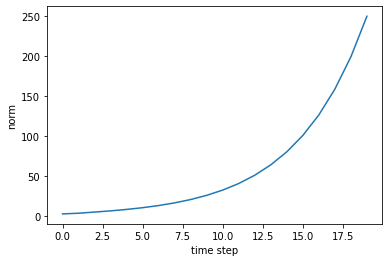

In [100]:
### Matmul 노드에서 기울기 폭발이 일어나는 이유
N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)
    
x = np.arange(T)
plt.plot(x, norm_list)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

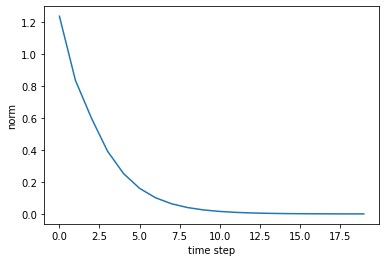

In [101]:
### Matmul 노드에서 기울기 소실이 일어나는 이유
N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = 0.5 * np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh ** 2)) / N
    norm_list.append(norm)
    
x = np.arange(T)
plt.plot(x, norm_list)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

In [102]:
### 기울기 폭발 대책 : 기울기 클리핑(gradients clipping)
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [103]:
dW1 = np.random.rand(3,3) * 10
dW2 = np.random.rand(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

In [104]:
total_sum = np.sum(dW1 ** 2) + np.sum(dW2 ** 2)
np.sqrt(total_sum)

21.70996045068755

In [105]:
from common.functions import *

In [106]:
### LSTM 구현
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = c_prev * f + g * i
        h_next = np.tanh(c_next) * o
        
        self.cache = (x, h_prev, c_prev, f, i, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, f, i, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dh_next + (dh_next * o) * (1-tanh_c_next**2)
        
        dc_prev = ds * f
        
        df = ds * c_prev
        dg = ds * i
        di = ds * g
        do = dh_next * tanh_c_next
        
        df *= f * (1-f)
        dg *= (1-g**2)
        di *= i * (1-i)
        do *= o * (1-o)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = np.sum(dA, axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

In [107]:
B=np.random.rand(2,3)
C=np.random.rand(2,3)
D=np.random.rand(2,3)
E=np.random.rand(2,3)

F = np.hstack((B,C,D,E))
F

array([[0.97599542, 0.67238368, 0.90283411, 0.6534109 , 0.55784076,
        0.36156476, 0.26923558, 0.29179277, 0.4576864 , 0.27797751,
        0.45462208, 0.20541034],
       [0.84575087, 0.37799404, 0.09221701, 0.2250545 , 0.40651992,
        0.46894025, 0.86053391, 0.5862529 , 0.28348786, 0.20137871,
        0.51403506, 0.08722937]])

In [108]:
B, C, D, E

(array([[0.97599542, 0.67238368, 0.90283411],
        [0.84575087, 0.37799404, 0.09221701]]),
 array([[0.6534109 , 0.55784076, 0.36156476],
        [0.2250545 , 0.40651992, 0.46894025]]),
 array([[0.26923558, 0.29179277, 0.4576864 ],
        [0.86053391, 0.5862529 , 0.28348786]]),
 array([[0.27797751, 0.45462208, 0.20541034],
        [0.20137871, 0.51403506, 0.08722937]]))

In [109]:
import pickle
from common.time_layers import *

In [110]:
### TimeLSTM 구현
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h = None
        self.c = None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N,H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None

In [111]:
### LSTM 계층을 사용하는 언어모델 구현
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        embd_W = (np.random.randn(V, D) / 100).astype('f')
        lstm_Wx = (np.random.randn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (np.random.randn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype('f')
        affien_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embd_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affien_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

In [112]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

In [113]:
plt.rcParams['font.family'] = 'AppleGothic'

In [114]:
### PTB 데이터셋 학습
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

In [115]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

In [116]:
corpus_test, word_to_id_test, id_to_word_test = ptb.load_data('test')

In [117]:
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [118]:
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.53
| 에폭 1 |  반복 21 / 1327 | 시간 2[s] | 퍼플렉서티 2921.77
| 에폭 1 |  반복 41 / 1327 | 시간 5[s] | 퍼플렉서티 1194.53
| 에폭 1 |  반복 61 / 1327 | 시간 7[s] | 퍼플렉서티 971.05
| 에폭 1 |  반복 81 / 1327 | 시간 10[s] | 퍼플렉서티 783.59
| 에폭 1 |  반복 101 / 1327 | 시간 12[s] | 퍼플렉서티 631.10
| 에폭 1 |  반복 121 / 1327 | 시간 14[s] | 퍼플렉서티 652.97
| 에폭 1 |  반복 141 / 1327 | 시간 17[s] | 퍼플렉서티 601.33
| 에폭 1 |  반복 161 / 1327 | 시간 19[s] | 퍼플렉서티 581.93
| 에폭 1 |  반복 181 / 1327 | 시간 21[s] | 퍼플렉서티 582.44
| 에폭 1 |  반복 201 / 1327 | 시간 24[s] | 퍼플렉서티 501.20
| 에폭 1 |  반복 221 / 1327 | 시간 26[s] | 퍼플렉서티 483.51
| 에폭 1 |  반복 241 / 1327 | 시간 29[s] | 퍼플렉서티 436.86
| 에폭 1 |  반복 261 / 1327 | 시간 31[s] | 퍼플렉서티 466.59
| 에폭 1 |  반복 281 / 1327 | 시간 34[s] | 퍼플렉서티 451.01
| 에폭 1 |  반복 301 / 1327 | 시간 37[s] | 퍼플렉서티 390.96
| 에폭 1 |  반복 321 / 1327 | 시간 39[s] | 퍼플렉서티 342.03
| 에폭 1 |  반복 341 / 1327 | 시간 42[s] | 퍼플렉서티 405.32
| 에폭 1 |  반복 361 / 1327 | 시간 44[s] | 퍼플렉서티 406.56
| 에폭 1 |  반복 381 / 1327 | 시간 46[s] | 퍼플렉서티 328.75
| 에폭 1

| 에폭 3 |  반복 561 / 1327 | 시간 381[s] | 퍼플렉서티 118.62
| 에폭 3 |  반복 581 / 1327 | 시간 383[s] | 퍼플렉서티 106.36
| 에폭 3 |  반복 601 / 1327 | 시간 386[s] | 퍼플렉서티 147.11
| 에폭 3 |  반복 621 / 1327 | 시간 388[s] | 퍼플렉서티 142.89
| 에폭 3 |  반복 641 / 1327 | 시간 391[s] | 퍼플렉서티 128.47
| 에폭 3 |  반복 661 / 1327 | 시간 393[s] | 퍼플렉서티 119.80
| 에폭 3 |  반복 681 / 1327 | 시간 395[s] | 퍼플렉서티 100.50
| 에폭 3 |  반복 701 / 1327 | 시간 398[s] | 퍼플렉서티 118.60
| 에폭 3 |  반복 721 / 1327 | 시간 400[s] | 퍼플렉서티 126.05
| 에폭 3 |  반복 741 / 1327 | 시간 402[s] | 퍼플렉서티 108.58
| 에폭 3 |  반복 761 / 1327 | 시간 405[s] | 퍼플렉서티 103.98
| 에폭 3 |  반복 781 / 1327 | 시간 407[s] | 퍼플렉서티 103.54
| 에폭 3 |  반복 801 / 1327 | 시간 409[s] | 퍼플렉서티 115.90
| 에폭 3 |  반복 821 / 1327 | 시간 412[s] | 퍼플렉서티 116.76
| 에폭 3 |  반복 841 / 1327 | 시간 414[s] | 퍼플렉서티 115.15
| 에폭 3 |  반복 861 / 1327 | 시간 417[s] | 퍼플렉서티 121.30
| 에폭 3 |  반복 881 / 1327 | 시간 419[s] | 퍼플렉서티 106.02
| 에폭 3 |  반복 901 / 1327 | 시간 421[s] | 퍼플렉서티 131.60
| 에폭 3 |  반복 921 / 1327 | 시간 424[s] | 퍼플렉서티 119.40
| 에폭 3 |  반복 941 / 1327 | 시간 42

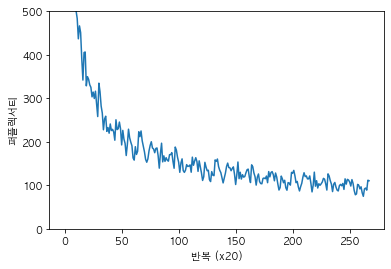

In [119]:
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0,500))

In [120]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print(f'테스트 퍼플렉서티: {ppl_test}')

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티: 135.16214901081506


In [122]:
from common.base_model import BaseModel

In [123]:
### RNNLM 개선 : 1. LSTM 계층의 다층화, 2. 드롭아웃 사용 (깊이 방향으로만), 3. 가중치 공유 (Affine, Embedding 계층)
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        embed_W = (np.random.randn(V,D) / 100).astype('f')
        lstm_Wx1 = (np.random.randn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_Wx2 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (np.random.randn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [124]:
### BetterRnnlm 모델 학습
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

In [125]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

In [126]:
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model,optimizer)

In [127]:
best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print(f'검증 퍼플렉서티: {ppl}')
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
        
    else:
        lr /= 4.0
        optimizer.lr = lr
        
    model.reset_state()
    print('-' * 50)

| 에폭 1 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 10000.38
| 에폭 1 |  반복 21 / 1327 | 시간 32[s] | 퍼플렉서티 4856.57
| 에폭 1 |  반복 41 / 1327 | 시간 60[s] | 퍼플렉서티 1789.32
| 에폭 1 |  반복 61 / 1327 | 시간 90[s] | 퍼플렉서티 1292.60
| 에폭 1 |  반복 81 / 1327 | 시간 120[s] | 퍼플렉서티 1041.54
| 에폭 1 |  반복 101 / 1327 | 시간 149[s] | 퍼플렉서티 829.28
| 에폭 1 |  반복 121 / 1327 | 시간 179[s] | 퍼플렉서티 773.86
| 에폭 1 |  반복 141 / 1327 | 시간 210[s] | 퍼플렉서티 711.58
| 에폭 1 |  반복 161 / 1327 | 시간 241[s] | 퍼플렉서티 670.11
| 에폭 1 |  반복 181 / 1327 | 시간 272[s] | 퍼플렉서티 682.67
| 에폭 1 |  반복 201 / 1327 | 시간 303[s] | 퍼플렉서티 573.70
| 에폭 1 |  반복 221 / 1327 | 시간 334[s] | 퍼플렉서티 570.04
| 에폭 1 |  반복 241 / 1327 | 시간 365[s] | 퍼플렉서티 520.28
| 에폭 1 |  반복 261 / 1327 | 시간 396[s] | 퍼플렉서티 525.89
| 에폭 1 |  반복 281 / 1327 | 시간 427[s] | 퍼플렉서티 514.43
| 에폭 1 |  반복 301 / 1327 | 시간 459[s] | 퍼플렉서티 454.91
| 에폭 1 |  반복 321 / 1327 | 시간 491[s] | 퍼플렉서티 398.46
| 에폭 1 |  반복 341 / 1327 | 시간 522[s] | 퍼플렉서티 452.98
| 에폭 1 |  반복 361 / 1327 | 시간 553[s] | 퍼플렉서티 466.69
| 에폭 1 |  반복 381 / 1327 | 시간 586[s] 

| 에폭 3 |  반복 441 / 1327 | 시간 691[s] | 퍼플렉서티 147.07
| 에폭 3 |  반복 461 / 1327 | 시간 724[s] | 퍼플렉서티 148.63
| 에폭 3 |  반복 481 / 1327 | 시간 755[s] | 퍼플렉서티 145.99
| 에폭 3 |  반복 501 / 1327 | 시간 787[s] | 퍼플렉서티 160.23
| 에폭 3 |  반복 521 / 1327 | 시간 817[s] | 퍼플렉서티 160.33
| 에폭 3 |  반복 541 / 1327 | 시간 849[s] | 퍼플렉서티 169.04
| 에폭 3 |  반복 561 / 1327 | 시간 880[s] | 퍼플렉서티 144.86
| 에폭 3 |  반복 581 / 1327 | 시간 911[s] | 퍼플렉서티 131.95
| 에폭 3 |  반복 601 / 1327 | 시간 942[s] | 퍼플렉서티 181.37
| 에폭 3 |  반복 621 / 1327 | 시간 974[s] | 퍼플렉서티 169.17
| 에폭 3 |  반복 641 / 1327 | 시간 1005[s] | 퍼플렉서티 156.94
| 에폭 3 |  반복 661 / 1327 | 시간 1037[s] | 퍼플렉서티 147.47
| 에폭 3 |  반복 681 / 1327 | 시간 1068[s] | 퍼플렉서티 124.39
| 에폭 3 |  반복 701 / 1327 | 시간 1100[s] | 퍼플렉서티 147.68
| 에폭 3 |  반복 721 / 1327 | 시간 1131[s] | 퍼플렉서티 149.83
| 에폭 3 |  반복 741 / 1327 | 시간 1162[s] | 퍼플렉서티 130.56
| 에폭 3 |  반복 761 / 1327 | 시간 1193[s] | 퍼플렉서티 125.28
| 에폭 3 |  반복 781 / 1327 | 시간 1224[s] | 퍼플렉서티 128.87
| 에폭 3 |  반복 801 / 1327 | 시간 1256[s] | 퍼플렉서티 145.39
| 에폭 3 |  반복 821 / 132

| 에폭 5 |  반복 861 / 1327 | 시간 1348[s] | 퍼플렉서티 114.40
| 에폭 5 |  반복 881 / 1327 | 시간 1379[s] | 퍼플렉서티 104.81
| 에폭 5 |  반복 901 / 1327 | 시간 1410[s] | 퍼플렉서티 133.06
| 에폭 5 |  반복 921 / 1327 | 시간 1442[s] | 퍼플렉서티 117.54
| 에폭 5 |  반복 941 / 1327 | 시간 1473[s] | 퍼플렉서티 122.34
| 에폭 5 |  반복 961 / 1327 | 시간 1504[s] | 퍼플렉서티 132.27
| 에폭 5 |  반복 981 / 1327 | 시간 1536[s] | 퍼플렉서티 125.50
| 에폭 5 |  반복 1001 / 1327 | 시간 1567[s] | 퍼플렉서티 107.76
| 에폭 5 |  반복 1021 / 1327 | 시간 1599[s] | 퍼플렉서티 127.81
| 에폭 5 |  반복 1041 / 1327 | 시간 1631[s] | 퍼플렉서티 112.28
| 에폭 5 |  반복 1061 / 1327 | 시간 1662[s] | 퍼플렉서티 103.83
| 에폭 5 |  반복 1081 / 1327 | 시간 1693[s] | 퍼플렉서티 89.51
| 에폭 5 |  반복 1101 / 1327 | 시간 1725[s] | 퍼플렉서티 91.97
| 에폭 5 |  반복 1121 / 1327 | 시간 1756[s] | 퍼플렉서티 124.76
| 에폭 5 |  반복 1141 / 1327 | 시간 1788[s] | 퍼플렉서티 117.00
| 에폭 5 |  반복 1161 / 1327 | 시간 1820[s] | 퍼플렉서티 101.84
| 에폭 5 |  반복 1181 / 1327 | 시간 1851[s] | 퍼플렉서티 107.22
| 에폭 5 |  반복 1201 / 1327 | 시간 1883[s] | 퍼플렉서티 91.35
| 에폭 5 |  반복 1221 / 1327 | 시간 1915[s] | 퍼플렉서티 90.42
| 에폭

| 에폭 7 |  반복 1301 / 1327 | 시간 2045[s] | 퍼플렉서티 113.42
| 에폭 7 |  반복 1321 / 1327 | 시간 2077[s] | 퍼플렉서티 112.84
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티: 108.48767523872526
--------------------------------------------------
| 에폭 8 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 139.99
| 에폭 8 |  반복 21 / 1327 | 시간 34[s] | 퍼플렉서티 100.14
| 에폭 8 |  반복 41 / 1327 | 시간 66[s] | 퍼플렉서티 98.86
| 에폭 8 |  반복 61 / 1327 | 시간 97[s] | 퍼플렉서티 93.62
| 에폭 8 |  반복 81 / 1327 | 시간 128[s] | 퍼플렉서티 81.76
| 에폭 8 |  반복 101 / 1327 | 시간 159[s] | 퍼플렉서티 81.54
| 에폭 8 |  반복 121 / 1327 | 시간 191[s] | 퍼플렉서티 87.17
| 에폭 8 |  반복 141 / 1327 | 시간 223[s] | 퍼플렉서티 94.90
| 에폭 8 |  반복 161 / 1327 | 시간 253[s] | 퍼플렉서티 108.89
| 에폭 8 |  반복 181 / 1327 | 시간 285[s] | 퍼플렉서티 114.15
| 에폭 8 |  반복 201 / 1327 | 시간 317[s] | 퍼플렉서티 110.95
| 에폭 8 |  반복 221 / 1327 | 시간 349[s] | 퍼플렉서티 108.81
| 에폭 8 |  반복 241 / 1327 | 시간 381[s] | 퍼플렉서티 102.77
| 에폭 8 |  반복 261 / 1327 | 시간 412[s] | 퍼플렉서티 109.01
| 에폭 8 |  반복 281 / 1327 | 시간 443[s] | 퍼플렉서티 107.78
| 에폭 8 |  반복 301 / 1327 | 시간 475[s] | 퍼플렉

| 에폭 10 |  반복 381 / 1327 | 시간 600[s] | 퍼플렉서티 84.22
| 에폭 10 |  반복 401 / 1327 | 시간 632[s] | 퍼플렉서티 94.54
| 에폭 10 |  반복 421 / 1327 | 시간 663[s] | 퍼플렉서티 82.96
| 에폭 10 |  반복 441 / 1327 | 시간 695[s] | 퍼플렉서티 87.81
| 에폭 10 |  반복 461 / 1327 | 시간 726[s] | 퍼플렉서티 88.28
| 에폭 10 |  반복 481 / 1327 | 시간 758[s] | 퍼플렉서티 86.10
| 에폭 10 |  반복 501 / 1327 | 시간 789[s] | 퍼플렉서티 96.63
| 에폭 10 |  반복 521 / 1327 | 시간 821[s] | 퍼플렉서티 97.85
| 에폭 10 |  반복 541 / 1327 | 시간 853[s] | 퍼플렉서티 100.42
| 에폭 10 |  반복 561 / 1327 | 시간 884[s] | 퍼플렉서티 83.95
| 에폭 10 |  반복 581 / 1327 | 시간 916[s] | 퍼플렉서티 79.33
| 에폭 10 |  반복 601 / 1327 | 시간 948[s] | 퍼플렉서티 109.97
| 에폭 10 |  반복 621 / 1327 | 시간 979[s] | 퍼플렉서티 103.06
| 에폭 10 |  반복 641 / 1327 | 시간 1011[s] | 퍼플렉서티 95.32
| 에폭 10 |  반복 661 / 1327 | 시간 1043[s] | 퍼플렉서티 86.82
| 에폭 10 |  반복 681 / 1327 | 시간 1076[s] | 퍼플렉서티 76.52
| 에폭 10 |  반복 701 / 1327 | 시간 1107[s] | 퍼플렉서티 89.91
| 에폭 10 |  반복 721 / 1327 | 시간 1139[s] | 퍼플렉서티 90.87
| 에폭 10 |  반복 741 / 1327 | 시간 1171[s] | 퍼플렉서티 80.60
| 에폭 10 |  반복 761 / 13

| 에폭 12 |  반복 801 / 1327 | 시간 1261[s] | 퍼플렉서티 83.06
| 에폭 12 |  반복 821 / 1327 | 시간 1291[s] | 퍼플렉서티 84.80
| 에폭 12 |  반복 841 / 1327 | 시간 1322[s] | 퍼플렉서티 84.72
| 에폭 12 |  반복 861 / 1327 | 시간 1354[s] | 퍼플렉서티 83.77
| 에폭 12 |  반복 881 / 1327 | 시간 1386[s] | 퍼플렉서티 76.19
| 에폭 12 |  반복 901 / 1327 | 시간 1417[s] | 퍼플렉서티 97.26
| 에폭 12 |  반복 921 / 1327 | 시간 1448[s] | 퍼플렉서티 86.50
| 에폭 12 |  반복 941 / 1327 | 시간 1479[s] | 퍼플렉서티 91.14
| 에폭 12 |  반복 961 / 1327 | 시간 1511[s] | 퍼플렉서티 96.99
| 에폭 12 |  반복 981 / 1327 | 시간 1543[s] | 퍼플렉서티 93.33
| 에폭 12 |  반복 1001 / 1327 | 시간 1574[s] | 퍼플렉서티 79.62
| 에폭 12 |  반복 1021 / 1327 | 시간 1605[s] | 퍼플렉서티 93.59
| 에폭 12 |  반복 1041 / 1327 | 시간 1636[s] | 퍼플렉서티 82.06
| 에폭 12 |  반복 1061 / 1327 | 시간 1667[s] | 퍼플렉서티 77.42
| 에폭 12 |  반복 1081 / 1327 | 시간 1698[s] | 퍼플렉서티 65.18
| 에폭 12 |  반복 1101 / 1327 | 시간 1730[s] | 퍼플렉서티 66.80
| 에폭 12 |  반복 1121 / 1327 | 시간 1761[s] | 퍼플렉서티 90.29
| 에폭 12 |  반복 1141 / 1327 | 시간 1793[s] | 퍼플렉서티 85.25
| 에폭 12 |  반복 1161 / 1327 | 시간 1824[s] | 퍼플렉서티 74.37
| 에

| 에폭 14 |  반복 1221 / 1327 | 시간 1918[s] | 퍼플렉서티 64.50
| 에폭 14 |  반복 1241 / 1327 | 시간 1950[s] | 퍼플렉서티 77.89
| 에폭 14 |  반복 1261 / 1327 | 시간 1982[s] | 퍼플렉서티 72.47
| 에폭 14 |  반복 1281 / 1327 | 시간 2014[s] | 퍼플렉서티 74.09
| 에폭 14 |  반복 1301 / 1327 | 시간 2045[s] | 퍼플렉서티 93.38
| 에폭 14 |  반복 1321 / 1327 | 시간 2077[s] | 퍼플렉서티 90.15
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티: 99.24230878657016
--------------------------------------------------
| 에폭 15 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 113.14
| 에폭 15 |  반복 21 / 1327 | 시간 33[s] | 퍼플렉서티 81.43
| 에폭 15 |  반복 41 / 1327 | 시간 64[s] | 퍼플렉서티 78.73
| 에폭 15 |  반복 61 / 1327 | 시간 95[s] | 퍼플렉서티 76.20
| 에폭 15 |  반복 81 / 1327 | 시간 127[s] | 퍼플렉서티 67.03
| 에폭 15 |  반복 101 / 1327 | 시간 158[s] | 퍼플렉서티 65.60
| 에폭 15 |  반복 121 / 1327 | 시간 190[s] | 퍼플렉서티 71.14
| 에폭 15 |  반복 141 / 1327 | 시간 222[s] | 퍼플렉서티 76.90
| 에폭 15 |  반복 161 / 1327 | 시간 254[s] | 퍼플렉서티 87.43
| 에폭 15 |  반복 181 / 1327 | 시간 284[s] | 퍼플렉서티 90.76
| 에폭 15 |  반복 201 / 1327 | 시간 316[s] | 퍼플렉서티 90.56
| 에폭 15 |  반복 221 / 1327 | 

| 에폭 17 |  반복 261 / 1327 | 시간 411[s] | 퍼플렉서티 78.94
| 에폭 17 |  반복 281 / 1327 | 시간 443[s] | 퍼플렉서티 74.73
| 에폭 17 |  반복 301 / 1327 | 시간 474[s] | 퍼플렉서티 63.22
| 에폭 17 |  반복 321 / 1327 | 시간 506[s] | 퍼플렉서티 51.71
| 에폭 17 |  반복 341 / 1327 | 시간 538[s] | 퍼플렉서티 71.70
| 에폭 17 |  반복 361 / 1327 | 시간 569[s] | 퍼플렉서티 72.78
| 에폭 17 |  반복 381 / 1327 | 시간 600[s] | 퍼플렉서티 62.89
| 에폭 17 |  반복 401 / 1327 | 시간 632[s] | 퍼플렉서티 72.20
| 에폭 17 |  반복 421 / 1327 | 시간 664[s] | 퍼플렉서티 61.74
| 에폭 17 |  반복 441 / 1327 | 시간 696[s] | 퍼플렉서티 65.53
| 에폭 17 |  반복 461 / 1327 | 시간 727[s] | 퍼플렉서티 65.91
| 에폭 17 |  반복 481 / 1327 | 시간 759[s] | 퍼플렉서티 65.30
| 에폭 17 |  반복 501 / 1327 | 시간 791[s] | 퍼플렉서티 71.65
| 에폭 17 |  반복 521 / 1327 | 시간 823[s] | 퍼플렉서티 73.18
| 에폭 17 |  반복 541 / 1327 | 시간 854[s] | 퍼플렉서티 74.71
| 에폭 17 |  반복 561 / 1327 | 시간 886[s] | 퍼플렉서티 63.26
| 에폭 17 |  반복 581 / 1327 | 시간 917[s] | 퍼플렉서티 59.36
| 에폭 17 |  반복 601 / 1327 | 시간 949[s] | 퍼플렉서티 83.34
| 에폭 17 |  반복 621 / 1327 | 시간 981[s] | 퍼플렉서티 75.87
| 에폭 17 |  반복 641 / 1327 | 시간 1

| 에폭 19 |  반복 681 / 1327 | 시간 1071[s] | 퍼플렉서티 53.27
| 에폭 19 |  반복 701 / 1327 | 시간 1102[s] | 퍼플렉서티 64.07
| 에폭 19 |  반복 721 / 1327 | 시간 1134[s] | 퍼플렉서티 61.98
| 에폭 19 |  반복 741 / 1327 | 시간 1165[s] | 퍼플렉서티 57.04
| 에폭 19 |  반복 761 / 1327 | 시간 1196[s] | 퍼플렉서티 51.56
| 에폭 19 |  반복 781 / 1327 | 시간 1227[s] | 퍼플렉서티 55.54
| 에폭 19 |  반복 801 / 1327 | 시간 1259[s] | 퍼플렉서티 61.47
| 에폭 19 |  반복 821 / 1327 | 시간 1291[s] | 퍼플렉서티 62.35
| 에폭 19 |  반복 841 / 1327 | 시간 1322[s] | 퍼플렉서티 62.28
| 에폭 19 |  반복 861 / 1327 | 시간 1353[s] | 퍼플렉서티 61.95
| 에폭 19 |  반복 881 / 1327 | 시간 1385[s] | 퍼플렉서티 56.29
| 에폭 19 |  반복 901 / 1327 | 시간 1416[s] | 퍼플렉서티 72.46
| 에폭 19 |  반복 921 / 1327 | 시간 1447[s] | 퍼플렉서티 64.19
| 에폭 19 |  반복 941 / 1327 | 시간 1479[s] | 퍼플렉서티 67.71
| 에폭 19 |  반복 961 / 1327 | 시간 1511[s] | 퍼플렉서티 71.75
| 에폭 19 |  반복 981 / 1327 | 시간 1542[s] | 퍼플렉서티 67.45
| 에폭 19 |  반복 1001 / 1327 | 시간 1573[s] | 퍼플렉서티 58.78
| 에폭 19 |  반복 1021 / 1327 | 시간 1605[s] | 퍼플렉서티 69.41
| 에폭 19 |  반복 1041 / 1327 | 시간 1637[s] | 퍼플렉서티 59.79
| 에폭 19 |

| 에폭 21 |  반복 1101 / 1327 | 시간 1750[s] | 퍼플렉서티 46.51
| 에폭 21 |  반복 1121 / 1327 | 시간 1781[s] | 퍼플렉서티 62.93
| 에폭 21 |  반복 1141 / 1327 | 시간 1813[s] | 퍼플렉서티 60.49
| 에폭 21 |  반복 1161 / 1327 | 시간 1845[s] | 퍼플렉서티 51.74
| 에폭 21 |  반복 1181 / 1327 | 시간 1876[s] | 퍼플렉서티 57.34
| 에폭 21 |  반복 1201 / 1327 | 시간 1907[s] | 퍼플렉서티 46.32
| 에폭 21 |  반복 1221 / 1327 | 시간 1939[s] | 퍼플렉서티 46.85
| 에폭 21 |  반복 1241 / 1327 | 시간 1971[s] | 퍼플렉서티 56.17
| 에폭 21 |  반복 1261 / 1327 | 시간 2002[s] | 퍼플렉서티 52.84
| 에폭 21 |  반복 1281 / 1327 | 시간 2034[s] | 퍼플렉서티 53.35
| 에폭 21 |  반복 1301 / 1327 | 시간 2065[s] | 퍼플렉서티 66.88
| 에폭 21 |  반복 1321 / 1327 | 시간 2097[s] | 퍼플렉서티 65.93
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티: 93.1290122303489
--------------------------------------------------
| 에폭 22 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 91.15
| 에폭 22 |  반복 21 / 1327 | 시간 32[s] | 퍼플렉서티 64.23
| 에폭 22 |  반복 41 / 1327 | 시간 64[s] | 퍼플렉서티 61.14
| 에폭 22 |  반복 61 / 1327 | 시간 96[s] | 퍼플렉서티 59.18
| 에폭 22 |  반복 81 / 1327 | 시간 127[s] | 퍼플렉서티 51.66
| 에폭 22 |  반복 101

| 에폭 24 |  반복 141 / 1327 | 시간 222[s] | 퍼플렉서티 55.51
| 에폭 24 |  반복 161 / 1327 | 시간 253[s] | 퍼플렉서티 64.79
| 에폭 24 |  반복 181 / 1327 | 시간 284[s] | 퍼플렉서티 68.09
| 에폭 24 |  반복 201 / 1327 | 시간 316[s] | 퍼플렉서티 67.73
| 에폭 24 |  반복 221 / 1327 | 시간 348[s] | 퍼플렉서티 65.72
| 에폭 24 |  반복 241 / 1327 | 시간 379[s] | 퍼플렉서티 61.29
| 에폭 24 |  반복 261 / 1327 | 시간 411[s] | 퍼플렉서티 66.22
| 에폭 24 |  반복 281 / 1327 | 시간 443[s] | 퍼플렉서티 63.81
| 에폭 24 |  반복 301 / 1327 | 시간 474[s] | 퍼플렉서티 53.04
| 에폭 24 |  반복 321 / 1327 | 시간 505[s] | 퍼플렉서티 44.50
| 에폭 24 |  반복 341 / 1327 | 시간 535[s] | 퍼플렉서티 61.36
| 에폭 24 |  반복 361 / 1327 | 시간 567[s] | 퍼플렉서티 62.22
| 에폭 24 |  반복 381 / 1327 | 시간 597[s] | 퍼플렉서티 53.89
| 에폭 24 |  반복 401 / 1327 | 시간 626[s] | 퍼플렉서티 62.06
| 에폭 24 |  반복 421 / 1327 | 시간 657[s] | 퍼플렉서티 52.65
| 에폭 24 |  반복 441 / 1327 | 시간 689[s] | 퍼플렉서티 55.82
| 에폭 24 |  반복 461 / 1327 | 시간 720[s] | 퍼플렉서티 57.25
| 에폭 24 |  반복 481 / 1327 | 시간 751[s] | 퍼플렉서티 56.61
| 에폭 24 |  반복 501 / 1327 | 시간 782[s] | 퍼플렉서티 61.46
| 에폭 24 |  반복 521 / 1327 | 시간 8

| 에폭 26 |  반복 581 / 1327 | 시간 834[s] | 퍼플렉서티 48.56
| 에폭 26 |  반복 601 / 1327 | 시간 862[s] | 퍼플렉서티 69.05
| 에폭 26 |  반복 621 / 1327 | 시간 892[s] | 퍼플렉서티 62.18
| 에폭 26 |  반복 641 / 1327 | 시간 919[s] | 퍼플렉서티 58.20
| 에폭 26 |  반복 661 / 1327 | 시간 948[s] | 퍼플렉서티 52.70
| 에폭 26 |  반복 681 / 1327 | 시간 977[s] | 퍼플렉서티 46.99
| 에폭 26 |  반복 701 / 1327 | 시간 1005[s] | 퍼플렉서티 56.47
| 에폭 26 |  반복 721 / 1327 | 시간 1033[s] | 퍼플렉서티 54.51
| 에폭 26 |  반복 741 / 1327 | 시간 1065[s] | 퍼플렉서티 49.74
| 에폭 26 |  반복 761 / 1327 | 시간 1095[s] | 퍼플렉서티 44.75
| 에폭 26 |  반복 781 / 1327 | 시간 1124[s] | 퍼플렉서티 47.26
| 에폭 26 |  반복 801 / 1327 | 시간 1152[s] | 퍼플렉서티 53.54
| 에폭 26 |  반복 821 / 1327 | 시간 1181[s] | 퍼플렉서티 54.91
| 에폭 26 |  반복 841 / 1327 | 시간 1210[s] | 퍼플렉서티 54.40
| 에폭 26 |  반복 861 / 1327 | 시간 1240[s] | 퍼플렉서티 53.02
| 에폭 26 |  반복 881 / 1327 | 시간 1267[s] | 퍼플렉서티 49.52
| 에폭 26 |  반복 901 / 1327 | 시간 1295[s] | 퍼플렉서티 63.07
| 에폭 26 |  반복 921 / 1327 | 시간 1323[s] | 퍼플렉서티 56.13
| 에폭 26 |  반복 941 / 1327 | 시간 1349[s] | 퍼플렉서티 59.15
| 에폭 26 |  반복 961 

| 에폭 28 |  반복 1001 / 1327 | 시간 1366[s] | 퍼플렉서티 50.25
| 에폭 28 |  반복 1021 / 1327 | 시간 1395[s] | 퍼플렉서티 58.23
| 에폭 28 |  반복 1041 / 1327 | 시간 1424[s] | 퍼플렉서티 51.31
| 에폭 28 |  반복 1061 / 1327 | 시간 1452[s] | 퍼플렉서티 48.47
| 에폭 28 |  반복 1081 / 1327 | 시간 1477[s] | 퍼플렉서티 40.17
| 에폭 28 |  반복 1101 / 1327 | 시간 1503[s] | 퍼플렉서티 41.43
| 에폭 28 |  반복 1121 / 1327 | 시간 1527[s] | 퍼플렉서티 55.34
| 에폭 28 |  반복 1141 / 1327 | 시간 1554[s] | 퍼플렉서티 52.71
| 에폭 28 |  반복 1161 / 1327 | 시간 1580[s] | 퍼플렉서티 45.54
| 에폭 28 |  반복 1181 / 1327 | 시간 1607[s] | 퍼플렉서티 50.15
| 에폭 28 |  반복 1201 / 1327 | 시간 1633[s] | 퍼플렉서티 40.90
| 에폭 28 |  반복 1221 / 1327 | 시간 1657[s] | 퍼플렉서티 41.16
| 에폭 28 |  반복 1241 / 1327 | 시간 1683[s] | 퍼플렉서티 49.75
| 에폭 28 |  반복 1261 / 1327 | 시간 1712[s] | 퍼플렉서티 47.53
| 에폭 28 |  반복 1281 / 1327 | 시간 1737[s] | 퍼플렉서티 48.04
| 에폭 28 |  반복 1301 / 1327 | 시간 1762[s] | 퍼플렉서티 58.33
| 에폭 28 |  반복 1321 / 1327 | 시간 1789[s] | 퍼플렉서티 57.25
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티: 92.18048623122021
----------------------------------------------

| 에폭 31 |  반복 41 / 1327 | 시간 62[s] | 퍼플렉서티 55.75
| 에폭 31 |  반복 61 / 1327 | 시간 93[s] | 퍼플렉서티 53.02
| 에폭 31 |  반복 81 / 1327 | 시간 124[s] | 퍼플렉서티 45.88
| 에폭 31 |  반복 101 / 1327 | 시간 155[s] | 퍼플렉서티 45.26
| 에폭 31 |  반복 121 / 1327 | 시간 186[s] | 퍼플렉서티 49.30
| 에폭 31 |  반복 141 / 1327 | 시간 217[s] | 퍼플렉서티 51.85
| 에폭 31 |  반복 161 / 1327 | 시간 247[s] | 퍼플렉서티 60.77
| 에폭 31 |  반복 181 / 1327 | 시간 278[s] | 퍼플렉서티 63.28
| 에폭 31 |  반복 201 / 1327 | 시간 308[s] | 퍼플렉서티 62.37
| 에폭 31 |  반복 221 / 1327 | 시간 339[s] | 퍼플렉서티 61.26
| 에폭 31 |  반복 241 / 1327 | 시간 370[s] | 퍼플렉서티 55.83
| 에폭 31 |  반복 261 / 1327 | 시간 400[s] | 퍼플렉서티 62.56
| 에폭 31 |  반복 281 / 1327 | 시간 431[s] | 퍼플렉서티 58.94
| 에폭 31 |  반복 301 / 1327 | 시간 461[s] | 퍼플렉서티 48.99
| 에폭 31 |  반복 321 / 1327 | 시간 492[s] | 퍼플렉서티 40.75
| 에폭 31 |  반복 341 / 1327 | 시간 522[s] | 퍼플렉서티 56.55
| 에폭 31 |  반복 361 / 1327 | 시간 554[s] | 퍼플렉서티 57.73
| 에폭 31 |  반복 381 / 1327 | 시간 584[s] | 퍼플렉서티 49.16
| 에폭 31 |  반복 401 / 1327 | 시간 614[s] | 퍼플렉서티 56.49
| 에폭 31 |  반복 421 / 1327 | 시간 645[s]

| 에폭 33 |  반복 481 / 1327 | 시간 732[s] | 퍼플렉서티 51.14
| 에폭 33 |  반복 501 / 1327 | 시간 763[s] | 퍼플렉서티 57.14
| 에폭 33 |  반복 521 / 1327 | 시간 793[s] | 퍼플렉서티 57.89
| 에폭 33 |  반복 541 / 1327 | 시간 824[s] | 퍼플렉서티 59.60
| 에폭 33 |  반복 561 / 1327 | 시간 854[s] | 퍼플렉서티 49.87
| 에폭 33 |  반복 581 / 1327 | 시간 885[s] | 퍼플렉서티 46.76
| 에폭 33 |  반복 601 / 1327 | 시간 916[s] | 퍼플렉서티 66.57
| 에폭 33 |  반복 621 / 1327 | 시간 947[s] | 퍼플렉서티 59.49
| 에폭 33 |  반복 641 / 1327 | 시간 977[s] | 퍼플렉서티 56.07
| 에폭 33 |  반복 661 / 1327 | 시간 1008[s] | 퍼플렉서티 49.80
| 에폭 33 |  반복 681 / 1327 | 시간 1039[s] | 퍼플렉서티 44.34
| 에폭 33 |  반복 701 / 1327 | 시간 1069[s] | 퍼플렉서티 52.81
| 에폭 33 |  반복 721 / 1327 | 시간 1101[s] | 퍼플렉서티 52.24
| 에폭 33 |  반복 741 / 1327 | 시간 1131[s] | 퍼플렉서티 48.32
| 에폭 33 |  반복 761 / 1327 | 시간 1162[s] | 퍼플렉서티 42.28
| 에폭 33 |  반복 781 / 1327 | 시간 1192[s] | 퍼플렉서티 46.30
| 에폭 33 |  반복 801 / 1327 | 시간 1223[s] | 퍼플렉서티 50.62
| 에폭 33 |  반복 821 / 1327 | 시간 1254[s] | 퍼플렉서티 52.38
| 에폭 33 |  반복 841 / 1327 | 시간 1284[s] | 퍼플렉서티 51.33
| 에폭 33 |  반복 861 / 1

| 에폭 35 |  반복 901 / 1327 | 시간 1363[s] | 퍼플렉서티 60.28
| 에폭 35 |  반복 921 / 1327 | 시간 1393[s] | 퍼플렉서티 54.28
| 에폭 35 |  반복 941 / 1327 | 시간 1423[s] | 퍼플렉서티 56.26
| 에폭 35 |  반복 961 / 1327 | 시간 1453[s] | 퍼플렉서티 59.54
| 에폭 35 |  반복 981 / 1327 | 시간 1484[s] | 퍼플렉서티 56.70
| 에폭 35 |  반복 1001 / 1327 | 시간 1514[s] | 퍼플렉서티 48.79
| 에폭 35 |  반복 1021 / 1327 | 시간 1545[s] | 퍼플렉서티 57.69
| 에폭 35 |  반복 1041 / 1327 | 시간 1575[s] | 퍼플렉서티 49.90
| 에폭 35 |  반복 1061 / 1327 | 시간 1605[s] | 퍼플렉서티 47.08
| 에폭 35 |  반복 1081 / 1327 | 시간 1636[s] | 퍼플렉서티 39.74
| 에폭 35 |  반복 1101 / 1327 | 시간 1666[s] | 퍼플렉서티 39.95
| 에폭 35 |  반복 1121 / 1327 | 시간 1698[s] | 퍼플렉서티 54.52
| 에폭 35 |  반복 1141 / 1327 | 시간 1726[s] | 퍼플렉서티 52.09
| 에폭 35 |  반복 1161 / 1327 | 시간 1754[s] | 퍼플렉서티 44.02
| 에폭 35 |  반복 1181 / 1327 | 시간 1779[s] | 퍼플렉서티 48.67
| 에폭 35 |  반복 1201 / 1327 | 시간 1805[s] | 퍼플렉서티 40.37
| 에폭 35 |  반복 1221 / 1327 | 시간 1832[s] | 퍼플렉서티 40.07
| 에폭 35 |  반복 1241 / 1327 | 시간 1860[s] | 퍼플렉서티 47.92
| 에폭 35 |  반복 1261 / 1327 | 시간 1891[s] | 퍼플렉서티 45.6

| 에폭 37 |  반복 1321 / 1327 | 시간 1690[s] | 퍼플렉서티 56.97
퍼플렉서티 평가 중 ...
209 / 210
검증 퍼플렉서티: 91.66635186087395
--------------------------------------------------
| 에폭 38 |  반복 1 / 1327 | 시간 1[s] | 퍼플렉서티 71.27
| 에폭 38 |  반복 21 / 1327 | 시간 26[s] | 퍼플렉서티 56.38
| 에폭 38 |  반복 41 / 1327 | 시간 51[s] | 퍼플렉서티 53.95
| 에폭 38 |  반복 61 / 1327 | 시간 77[s] | 퍼플렉서티 52.34
| 에폭 38 |  반복 81 / 1327 | 시간 101[s] | 퍼플렉서티 45.64
| 에폭 38 |  반복 101 / 1327 | 시간 128[s] | 퍼플렉서티 44.99
| 에폭 38 |  반복 121 / 1327 | 시간 154[s] | 퍼플렉서티 48.40
| 에폭 38 |  반복 141 / 1327 | 시간 178[s] | 퍼플렉서티 50.67
| 에폭 38 |  반복 161 / 1327 | 시간 203[s] | 퍼플렉서티 61.11
| 에폭 38 |  반복 181 / 1327 | 시간 228[s] | 퍼플렉서티 63.36
| 에폭 38 |  반복 201 / 1327 | 시간 252[s] | 퍼플렉서티 62.59
| 에폭 38 |  반복 221 / 1327 | 시간 277[s] | 퍼플렉서티 60.41
| 에폭 38 |  반복 241 / 1327 | 시간 302[s] | 퍼플렉서티 56.41
| 에폭 38 |  반복 261 / 1327 | 시간 327[s] | 퍼플렉서티 60.43
| 에폭 38 |  반복 281 / 1327 | 시간 352[s] | 퍼플렉서티 58.78
| 에폭 38 |  반복 301 / 1327 | 시간 377[s] | 퍼플렉서티 48.90
| 에폭 38 |  반복 321 / 1327 | 시간 402[s] |

| 에폭 40 |  반복 381 / 1327 | 시간 596[s] | 퍼플렉서티 49.14
| 에폭 40 |  반복 401 / 1327 | 시간 629[s] | 퍼플렉서티 55.59
| 에폭 40 |  반복 421 / 1327 | 시간 660[s] | 퍼플렉서티 48.66
| 에폭 40 |  반복 441 / 1327 | 시간 692[s] | 퍼플렉서티 50.67
| 에폭 40 |  반복 461 / 1327 | 시간 723[s] | 퍼플렉서티 51.81
| 에폭 40 |  반복 481 / 1327 | 시간 754[s] | 퍼플렉서티 51.06
| 에폭 40 |  반복 501 / 1327 | 시간 786[s] | 퍼플렉서티 56.11
| 에폭 40 |  반복 521 / 1327 | 시간 817[s] | 퍼플렉서티 57.45
| 에폭 40 |  반복 541 / 1327 | 시간 849[s] | 퍼플렉서티 58.98
| 에폭 40 |  반복 561 / 1327 | 시간 881[s] | 퍼플렉서티 49.90
| 에폭 40 |  반복 581 / 1327 | 시간 912[s] | 퍼플렉서티 46.25
| 에폭 40 |  반복 601 / 1327 | 시간 943[s] | 퍼플렉서티 65.27
| 에폭 40 |  반복 621 / 1327 | 시간 974[s] | 퍼플렉서티 58.85
| 에폭 40 |  반복 641 / 1327 | 시간 1006[s] | 퍼플렉서티 54.73
| 에폭 40 |  반복 661 / 1327 | 시간 1037[s] | 퍼플렉서티 50.84
| 에폭 40 |  반복 681 / 1327 | 시간 1068[s] | 퍼플렉서티 44.16
| 에폭 40 |  반복 701 / 1327 | 시간 1099[s] | 퍼플렉서티 52.78
| 에폭 40 |  반복 721 / 1327 | 시간 1130[s] | 퍼플렉서티 52.62
| 에폭 40 |  반복 741 / 1327 | 시간 1161[s] | 퍼플렉서티 47.32
| 에폭 40 |  반복 761 / 1327 

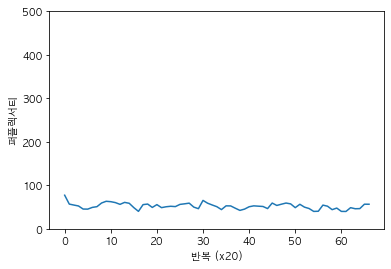

In [128]:
trainer.plot(ylim=(0,500))

In [129]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  87.23304733393125
